In [1]:
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain.agents import AgentExecutor
from typing_extensions import Annotated, TypedDict
from typing import Callable, Literal, Optional, Sequence, Type, TypeVar, Union, cast, List, Tuple, Any
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.tools import tool
import json

In [2]:
from sql_react_agent_llama import SQL_SUBAGENT, make_dataframe
from viz_agent import VIZ_AGENT
from initiate_llm import gpt_llm, llama_llm

import pandas as pd

INSIDE NL2SQL TOOL
{'messages': [HumanMessage(content='Give me the names of 5 employees along with their full time or part time status', additional_kwargs={}, response_metadata={}, id='766b821d-df21-4ce7-9fe9-344039beac82'), ToolMessage(content='{"question": "Give me the names of 5 employees along with their full time or part time status", "query": "SELECT \\"first_name\\", \\"last_name\\", \\"full_time_or_part_time\\" FROM analytical_schema.dim_ukg_employee_job_history_details LIMIT 5"}', name='nl2sql_tool', id='bec28af6-4a31-41f8-8fc2-ad7a0bc4b6a5', tool_call_id='tool_123'), ToolMessage(content='{"question": "Give me the names of 5 employees along with their full time or part time status", "query": "SELECT \\"first_name\\", \\"last_name\\", \\"full_time_or_part_time\\" FROM analytical_schema.dim_ukg_employee_job_history_details LIMIT 5", "result": "Error: (psycopg2.errors.UndefinedColumn) column \\"first_name\\" does not exist\\nLINE 1: SELECT \\"first_name\\", \\"last_name\\", \\"fu

##### Agent State and Setup

In [ ]:
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    question: Annotated[str, Field(description="The user question")]
    sql_query: Annotated[str, Field(description="The SQL query generated by the agent")]
    results: List[List[Union[int, float, str, bool]]] = Field(..., description="The results returned by the SQL agent as a list of tuples.")
    df: pd.DataFrame = Field(..., description="The table returned by the make_table node as a pandas dataframe.")
    python_visualization_code: Annotated[str, Field(description="The Python code to visualize the results")]



##### SQL Sub-agent

In [12]:
# nl2sql_agent = create_agent(gpt_llm, [nl2sql_tool], "nl2sql")

def nl2sql_node(state: AgentState) -> Command[Literal["supervisor"]]:
    last = state['messages'][-1]
    question = last.content
    try:
        question = json.loads(question)
        question = question["question"]
    except json.JSONDecodeError:
        pass        
    # print(last.content)
    result = SQL_SUBAGENT.invoke({"messages": [HumanMessage(content=last.content)]})
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="sql_agent")
            ],
            "question": question,
            "sql_query": json.loads(result["messages"][-1].content)['query'],
            "results": json.loads(result["messages"][-1].content)['result'],
        },
        goto="supervisor",
    )

##### Make table node

In [10]:
def make_table_node(state: AgentState) -> Command[Literal["supervisor"]]:
    query = state["sql_query"]
    results = state["results"]
    df = make_dataframe(query, results)
    return Command(
        update={
            "messages": [
                (
                    "assistant",
                    f"Here is the table I created from the results: {str(df)}"
                )
            ],
            "df": df,
        },
        goto="supervisor",
    )

#### Vizualisation Node

In [11]:
def viz_node(state: AgentState) -> Command[Literal["supervisor"]]:
    question = state["question"]
    df = state["df"]
    results = state["results"]
    viz_agent_state = {
        "question": question,
        "df": df,
        "results": results,
        "messages": [],
        "error": ""
    }

    response = VIZ_AGENT.invoke(viz_agent_state)
    viz_code = response["generation"].imports + "\n" + response["generation"].code
    return Command(
        update={
            
            "messages": [
                (
                "assistant",
                f"Here is the visualization code for plotting the data:\n {viz_code}",
                )
            ],
            "python_visualization_code": viz_code,
        },
        goto="supervisor",
    )

#### Setting up Supervisor

In [14]:
# Define available agents
members = ["sql_agent", "make_table", "viz_agent"]
# Add FINISH as an option for task completion
options = members + ["FINISH"]


In [36]:
supervisor_prompt = (
    """
    You are a supervisor agent named "SQLOrchestrator" tasked with managing the following workers (subagents/nodes): {members}.

Your job is to orchestrate a multi-step pipeline to answer the user's question stored in `AgentState.question`. You will examine the current `AgentState` fields in this order and decide which worker to invoke next:

1. **SQL Generation & Execution**  
   - If `AgentState.results` is empty (i.e. no SQL has been run), route to `sql_agent`.  
   - The `sql_agent` should generate an `AgentState.sql_query` based on `AgentState.question`, execute it against the database, populate `AgentState.results` (a list of tuples), and append its result message to the conversation.

2. **Table Construction**  
   - *Only* after the SQL has been run and populated the results, check if `AgentState.df` is empty. 
   - If `AgentState.df` is empty (i.e. no DataFrame has been built), route to `make_table`.  
   - The `make_table` node should take the raw `AgentState.results`, convert them into a pandas DataFrame `AgentState.df`, and append its result message to the conversation.

3. **Visualization Code**  
   - *Only* after the SQL has run, populated the results and the dataframe is made, check if `AgentState.python_visualization_code` is empty.
   - If `AgentState.python_visualization_code` is empty, route to `viz_agent`.  
   - The `viz_agent` should inspect `AgentState.df` and generate the Python code needed to visualize the data, set it in `AgentState.python_visualization_code`, and append its result message to the conversation.

4. **Finish & Respond**  
   - If all the necessary fields based on the intent of the question have been populated, route to `FINISH`.  
   - When routing to `FINISH`, produce a natural-language final answer that directly addresses `AgentState.question` by summarizing the contents of `AgentState.df` and, if provided, reference the visualization code in `AgentState.python_visualization_code`. Include any key insights or metrics the user asked for.
    """
)

In [29]:
# Define router type for structured output
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH - AND give the final answer."""

    """The worker to route to next."""
    next: Literal["sql_agent", "make_table_node", "viz_agent", "FINISH"]
    """The final answer to the user's question."""
    final_answer: str

In [30]:
# Create supervisor node function
def supervisor_node(state: AgentState) -> Command[Literal["sql_agent", "make_table_node", "viz_agent", "__end__"]]:
    messages = [
        {"role": "system", "content": supervisor_prompt},
    ] + state["messages"]
    print("\n\n========BACK TO SUPERVISOR========\n")

    state_info = {k: v for k, v in state.items() if k != 'messages'}

    messages = [
        {"role": "system", "content": supervisor_prompt},
        {"role": "user", "content": f"AgentState: {json.dumps(state_info, default=str)}"}
    ] + state["messages"]
    
    print("INVOKING WITH STATE INFO\n", state_info)
    response = gpt_llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END
        return Command(
            update={
                "messages": [
                    HumanMessage(content=response["final_answer"], name="supervisor")
                ]
            }
            ,goto=goto)
    
    return Command(goto=goto)

In [31]:
builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("sql_agent", nl2sql_node)
builder.add_node("make_table_node", make_table_node)
builder.add_node("viz_agent", viz_node)
graph = builder.compile()

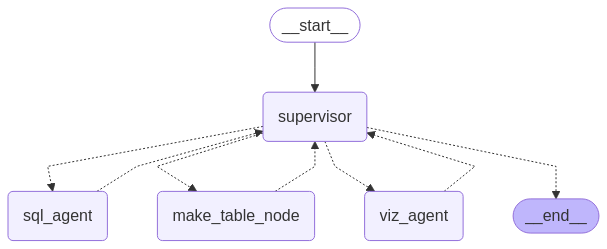

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # You can put your exception handling code here
    print(str(e))
    pass


In [39]:
initial_state = {
    "messages": [HumanMessage(content="Give me the number of employees present from each ethnicity")],
    "question": "",
    "sql_query": "",
    "results": "",
    "df": "",
    "python_visualization_code": ""
}

result = graph.invoke(
    initial_state
)

# print(result)




========BACK TO SUPERVISOR========

INVOKING WITH STATE INFO
 {'question': '', 'sql_query': '', 'results': '', 'df': '', 'python_visualization_code': ''}
Next Worker: sql_agent


========BACK TO SUPERVISOR========

INVOKING WITH STATE INFO
 {'question': 'Give me the number of employees present from each ethnicity', 'sql_query': 'SELECT "ethnic_description", COUNT(*) FROM analytical_schema.dim_ukg_employee_demographic_details GROUP BY "ethnic_description" LIMIT 5;', 'results': [['Hispanic or Latino', 81], ['Native American', 57], ['Asian', 67], ['White', 74], [None, 144]], 'df': '', 'python_visualization_code': ''}
Next Worker: make_table_node


========BACK TO SUPERVISOR========

INVOKING WITH STATE INFO
 {'question': 'Give me the number of employees present from each ethnicity', 'sql_query': 'SELECT "ethnic_description", COUNT(*) FROM analytical_schema.dim_ukg_employee_demographic_details GROUP BY "ethnic_description" LIMIT 5;', 'results': [['Hispanic or Latino', 81], ['Native Ameri

In [42]:
print(result['messages'][-1])
print(result["python_visualization_code"])
print(result["sql_query"])
result["df"]

content='The number of employees present from each ethnicity is summarized as follows:\n\n- Hispanic or Latino: 81\n- Native American: 57\n- Asian: 67\n- White: 74\n- Undefined/Not Specified: 144\n\nI have also provided Python code to create a bar chart visualizing this data using Plotly.' additional_kwargs={} response_metadata={} name='supervisor' id='ac31a06a-4d24-43f0-a9e4-24bd6eb7bbf9'
import pandas as pd
import plotly.graph_objects as go
# Construct DataFrame from provided data
data = [['Hispanic or Latino', 81], ['Native American', 57], ['Asian', 67], ['White', 74], [None, 144]]
df = pd.DataFrame(data, columns=['ethnic_description', 'count'])

# Create a bar chart
fig = go.Figure()
fig.add_trace(go.Bar(x=df['ethnic_description'], y=df['count'], name='Employee Count'))

# Update layout of the figure
fig.update_layout(title='Number of Employees Present by Ethnicity',
                  xaxis_title='Ethnicity',
                  yaxis_title='Number of Employees')

fig
SELECT "ethnic_

,ethnic_description,count
0,Hispanic or Latino,81
1,Native American,57
2,Asian,67
3,White,74
4,None,144


In [75]:
result = graph.invoke(
    {"messages": [HumanMessage(content="Give me the number of part time employees for each ethnicity")]}
)

print(result)


Next Worker: sql_agent
Next Worker: FINISH
{'messages': [HumanMessage(content='Give me the number of part time employees for each ethnicity', additional_kwargs={}, response_metadata={}, id='b7411c0d-2b98-4868-a8cb-817264c0e89a'), HumanMessage(content='{"question": "Give me the number of part time employees for each ethnicity", "query": "SELECT T1.ethnic_description, COUNT(T1.employee_id) FROM analytical_schema.dim_ukg_employee_demographic_details AS T1 INNER JOIN analytical_schema.dim_ukg_employee_job_history_details AS T2 ON T1.employee_id = T2.employee_id WHERE T2.full_time_or_part_time = \'PART_TIME\' GROUP BY T1.ethnic_description", "result": ""}', additional_kwargs={}, response_metadata={}, name='sql_agent', id='1c150272-3229-466a-b70f-4ca83f88e947'), HumanMessage(content='The query did not return any results, which means there might not be any part-time employees recorded for each ethnicity in the database.', additional_kwargs={}, response_metadata={}, name='supervisor', id='7c00